In [50]:
import torch
import torchvision

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import catalyst

import numpy as np

In [2]:
from types import SimpleNamespace

args = SimpleNamespace(**{
    'no_cuda': True,
    'rand_seed': 10,
    'batch_size': 20
})

use_cuda = torch.cuda.is_available() and not args.no_cuda
device = torch.device('cuda' if use_cuda else 'cpu')

torch.manual_seed(args.rand_seed)
if use_cuda:
  torch.cuda.manual_seed(args.rand_seed)
np.random.seed(args.rand_seed)

# Dirichlet Prior Network

In [36]:
# Class with uncertainty measures

class DPNClass(nn.Module):
  
  def __init__(self, model):
    super(DPNClass, self).__init__()
    self.model = model
  
  def forward(self, x):
    """
    Get alphas for target dirichlet distribution.
    """
    return torch.exp(self.model.forward(x))
  
  def get_expected(self, x):
    """
    Get an expected probability vector.
    """
    alphas = self.forward(x)
    return alphas * (1 / alphas.sum(axis = 1))[:, None]

  ## Uncertainty measures

  ### Total uncertainty

  def max_prob(self, x):
    probs = self.get_expected(x)
    return torch.max(probs, axis=1).values

  def entropy(self, x):
    probs = self.get_expected(x)
    return -(probs * torch.log2(probs)).sum(axis = 1)

  def exp_of_entr(self, x):
    alphas = self.forward(x); precision = alphas.sum(axis = 1)
    return - torch.sum(alphas * (1/precision)[:, None] * 
                                      (torch.digamma(alphas+1) - torch.digamma(precision + 1)[:, None]), axis=1)
  ### Distributional uncertainty

  def mutual_info(self, x):
    """
    Mutual information between predicted label and mu - shows the spread of the ensamble.
    """  
    alphas = self.forward(x); precision = alphas.sum(axis = 1)

    entropy_of_expected = self.entropy(x)
    expected_of_entropy = self.exp_of_entr(x)

    return entropy_of_expected - expected_of_entropy
  
  def diff_entropy(self, x):
    """
    Differential entropy of resulting dirichlet distribution.
    """
    alphas = self.forward(x); precision = alphas.sum(axis = 1)

    lgamma_term = torch.lgamma(alphas)
    digamma_term = (alphas - 1) * (torch.digamma(alphas) - torch.digamma(precision)[:, None])

    return torch.sum(lgamma_term - digamma_term, axis=1) - torch.lgamma(precision)

In [4]:
# Loss function

## KL divergence

def dirichlet_kl_divergence(alphas, target_alphas, epsilon=1e-8):
  """
  Calculate kl divergence between two dirichlet distributions.
  epsilon: smoothing parameter for targets
  """

  precision = alphas.sum(axis = 1) + epsilon * alphas.shape[1]
  target_precision = target_alphas.sum(axis = 1) + epsilon * target_alphas.shape[1]

  precision_term = torch.lgamma(target_precision) - torch.lgamma(precision)

  alphas_term = torch.sum( torch.lgamma(alphas + epsilon) - torch.lgamma(target_alphas + epsilon) + 
   (target_alphas - alphas) * (torch.digamma(target_alphas + epsilon) - torch.digamma(target_precision)[:, None] ), axis = 1)
  
  cost = precision_term + alphas_term

  return cost

def dirichlet_reverse_kl_divergence(alphas, target_alphas, epsilon=1e-8):
  """
  Reverse kl divergence. Used as a distance metric in follow up paper. 
  """
  return dirichlet_kl_divergence(alphas=target_alphas, target_alphas=alphas, epsilon=epsilon)

In [5]:
class DirichletKLLoss(nn.Module):

  def __init__(self, target_concentration=1e2, base_concentration=1.0, reverse=True):
    super(DirichletKLLoss,self).__init__()
    self.target_concentration = target_concentration
    self.base_concentration = base_concentration
    self.reverse = reverse

  def forward(self, alphas, labels=None):
    costs = self.dirichlet_kl_loss(alphas, labels, self.target_concentration, self.base_concentration, self.reverse)
    return torch.sum(costs)
  
  @staticmethod 
  def dirichlet_kl_loss(alphas, labels=None, target_concentration=1e2, base_concentration=1.0, reverse=True):
    """
    alphas: batch_size * num_classes.
    labels: batch_size. If None - ood data is supposed.
    reverse: Should reverse kl divergence be used. 
    """

    # Make target distribution
    target_alphas = torch.ones_like(alphas) * base_concentration

    if labels is not None:
      target_alphas += torch.zeros_like(target_alphas).scatter_(1, labels[:,None], value=1) * target_concentration

    cost = 0
    if reverse:
      cost = dirichlet_reverse_kl_divergence(alphas, target_alphas)
    else:
      cost = dirichlet_kl_divergence(alphas, target_alphas)
    
    return cost

In [19]:
# To iterate domain and ood data on one batch
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets
        self.length = max(len(d) for d in self.datasets) 

    def __getitem__(self, i):
        return tuple(d[i % len(d)] for d in self.datasets)

    def __len__(self):
        return self.length

In [20]:
# Special catalyst runner
class PriorNetRunner(catalyst.dl.Runner):

  def _handle_batch(self, batch):

    dom_data, ood_data = batch
    dom_loss = self.criterion(self.model(dom_data[0]), dom_data[1])
    ood_loss = self.criterion(self.model(ood_data[0]))

    self.batch_metrics.update({"loss": dom_loss + ood_loss})

# Experiments


In [ ]:
!pip install catalyst

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import catalyst
from catalyst.dl import SupervisedRunner
from torch.utils.data import DataLoader, TensorDataset
from dataclasses import dataclass

### Synthetic data

In [8]:
# Generate mixture of gaussians

def gen_three_gaussians(a, std, num_points):
  """
  a: distance between gaussian centers
  num_points: points for each class
  """
  centers = np.array([
    [0,np.sqrt(3)/3 * a], [-a/2, -np.sqrt(3)/6 * a], [a/2, -np.sqrt(3)/6 * a]
  ])

  data_X, data_Y = [], []

  for i, c in enumerate(centers):
    data_X.extend(np.random.multivariate_normal(c, std * np.identity(c.shape[0]), num_points))
    data_Y.extend([i for _ in range(num_points)])
  
  return np.array(data_X), np.array(data_Y)


def gen_ood(center, radius, width, num_points):

  angles = np.random.uniform(0,1,num_points) * 2 * np.pi
  radiuses = radius + width * np.random.uniform(0,1,num_points)

  return np.column_stack( [center[0] + radiuses * np.cos(angles), center[1] + radiuses * np.sin(angles)] )

In [16]:
class ToyModel(nn.Module):
  def __init__(self):
    super(ToyModel, self).__init__()
    self.fc1 = nn.Linear(2, 50)
    self.out = nn.Linear(50, 3)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    return self.out(x)

In [68]:
def viz_metrics(metrics_list, names, lim, train_X=None, ood_X=None, show_data=False):
  """
  metrics_list: list of functions to be evaluated
  """

  xs, ys = torch.linspace(-lim, lim), torch.linspace(-lim, lim)
  points = torch.stack(torch.meshgrid([xs, ys]), dim=-1).view([-1, 2])

  fig, axs = plt.subplots(1, len(metrics_list), figsize=(15,5))

  for i, (n, metr) in enumerate(zip(names, metrics_list)):
    vals = metr(points).detach()

    # Plots
    
    c = axs[i].pcolormesh(xs.numpy(), ys.numpy(), vals.view(100,100).numpy(), cmap='RdBu')
    axs[i].set_title(n)
    axs[i].set(adjustable='box', aspect='equal')
    
    if show_data:
      axs[i].scatter(train_X[:,0].numpy(), train_X[:,1].numpy(), c='white', alpha=0.01)
      axs[i].scatter(ood_X[:,0].numpy(), ood_X[:,1].numpy(), c='blue', alpha=0.01)

    fig.colorbar(c, ax=axs[i])

  plt.show()

In [77]:
class SilentLogg(catalyst.core.callbacks.logging.ConsoleLogger):
  def __init__(self):
    super(SilentLogg, self).__init__()
  def on_epoch_end(self, runner: catalyst.core.runner.IRunner):
    pass

In [75]:
@dataclass
class SyntheticConfig:
  model: nn.Module
  name: str = "Experiment on synthetic data."
  center_dist: float = 10
  std: float = 4
  ood_border: float = 15
  data_num: int = 500
  ood_num: int = 600
  reverse: bool = True
  num_epochs: int = 60


def run_synthetic_experiment(config: SyntheticConfig, device):
  
  print("Running ", config.name)

  # Generate data
  train_Toy_X, train_Toy_Y = gen_three_gaussians(
                                 config.center_dist, 
                                 config.std,
                                 config.data_num,
                                 )
  ood_Toy_X = gen_ood( 
      [0,0], 
      config.ood_border, 
      config.center_dist/4, 
      config.ood_num)
  
  train_X = torch.Tensor(train_Toy_X).to(device); train_Y = torch.Tensor(train_Toy_Y).type(torch.int64).to(device)
  ood_X = torch.Tensor(ood_Toy_X).to(device)

  # Training
  model_copy = copy.deepcopy(config.model)

  runner = PriorNetRunner()
  criterion = DirichletKLLoss(reverse=config.reverse)
  optimizer = torch.optim.Adam(model_copy.parameters()) 
  prior_dataset = ConcatDataset(TensorDataset(train_X, train_Y), TensorDataset(ood_X))

  runner.train(
    model=model_copy, criterion=criterion, optimizer=optimizer, 
    loaders={'train':DataLoader(prior_dataset, batch_size=20, shuffle=True)}, 
    num_epochs=config.num_epochs,
    callbacks={
        "optimizer": catalyst.dl.OptimizerCallback(
        metric_key="loss", 
        accumulation_steps=1,
        grad_clip_params=None,
        ),
        "logger": SilentLogg()
    },
    verbose=False,
    logdir='logs'
  )

  # Evaluation

  viz_metrics( [model_copy.max_prob, model_copy.entropy, model_copy.exp_of_entr, model_copy.mutual_info, model_copy.diff_entropy], 
              ['max_prob', 'entropy', 'exp_entr', 'mutual_info', 'diff_entropy'], 
              20, train_X, ood_X, show_data=True)

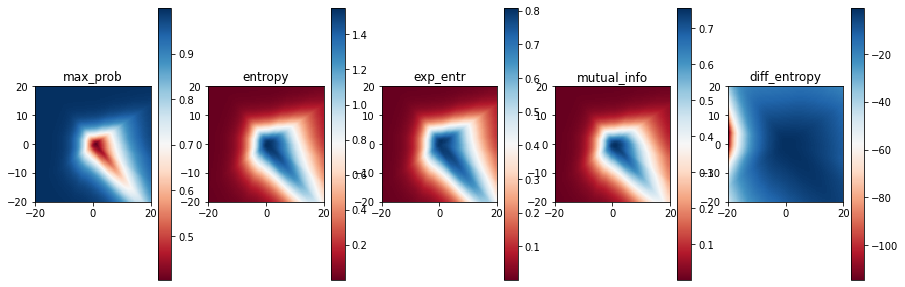

In [81]:
dpn = DPNClass(ToyModel()).to(device)
viz_metrics([dpn.max_prob, dpn.entropy, dpn.exp_of_entr, dpn.mutual_info, dpn.diff_entropy], ['max_prob', 'entropy', 'exp_entr', 'mutual_info', 'diff_entropy'], 20)

Running  Standart experiment


/usr/local/lib/python3.6/dist-packages/catalyst/dl/experiment/experiment.py:190: UserWarning:

Attention, there is only one dataloader - train



Top best models:
logs/checkpoints/train.59.pth	69.1139


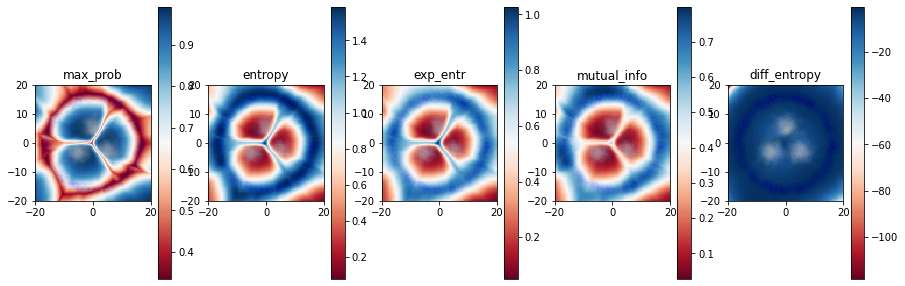

Running  Forward loss experiment
Top best models:
logs/checkpoints/train.60.pth	30.0882


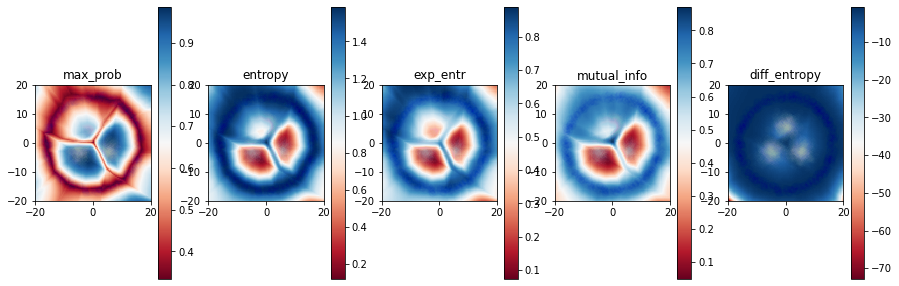

Running  High noise experiment
Top best models:
logs/checkpoints/train.60.pth	328.3013


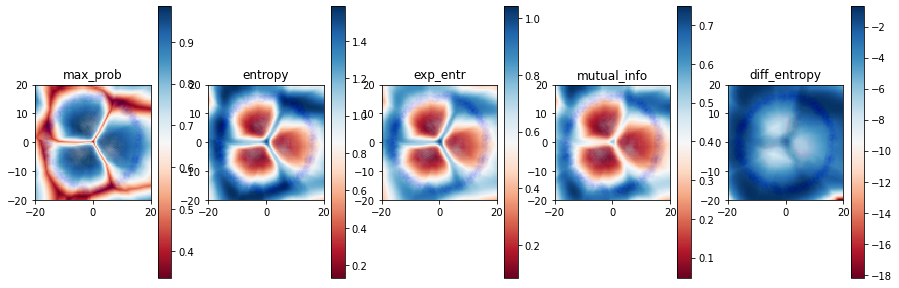

In [82]:
experiments = [
  SyntheticConfig(dpn, "Standart experiment"),
  SyntheticConfig(dpn, "Forward loss experiment", reverse=False),
  SyntheticConfig(dpn, "High noise experiment", std=7),
  
]

for conf in experiments:
  run_synthetic_experiment(conf, device)

### Classification error

In [ ]:
import os
data_path = os.path.join('data', 'mnist')

In [ ]:
train_MNIST = datasets.MNIST(data_path, train=True, download=True,
                            transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))]))
test_MNIST = datasets.MNIST(data_path, train=False, transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))]))

train_MNIST_loader = DataLoader(train_MNIST, batch_size=args.batch_size,
                          shuffle=True, num_workers=4, pin_memory=True)
test_MNIST_loader = DataLoader(test_MNIST, batch_size=args.batch_size,
                         num_workers=4, pin_memory=True)

### Missclassification detection

### OOD-detection